<a href="https://colab.research.google.com/github/drwadu/simcjt/blob/master/Tark_gVfB_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This project contains the implementation details for the simulations used in the submission "Questions about Quantities".

Each cell contains a self-contatining implementation of a differnet kind of simulation. It is organized as follows:

1. Unweighted Aggregation - Normal Distribution - No Correlation
2. Weighted Aggregation - Normal Distribution - No Correlation
3. Unweighted Aggregation - Exponential Distribution - No Correlation
4. Unweighted Aggregation - Normal Distribution - Correlation through Opinion Leader

Unweighted Aggregation - Normal Distribution - No Correlation

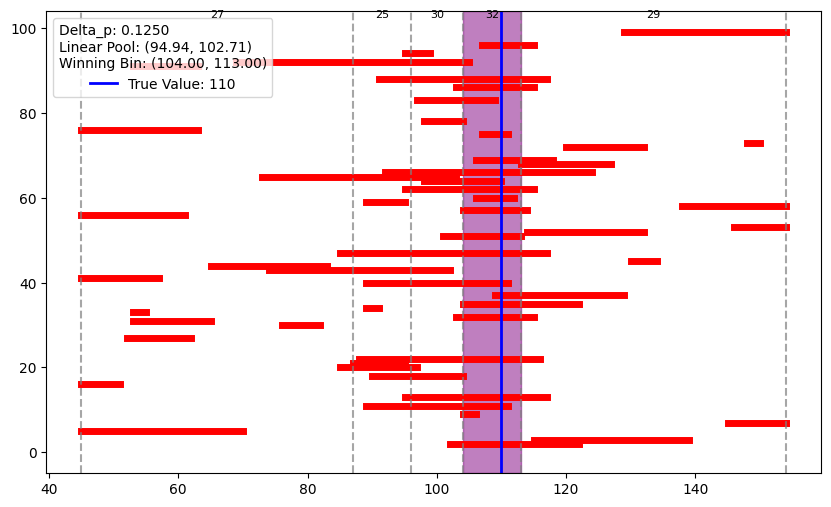

percentile_values:[ 45  87  96 104 113 154]


In [ ]:
#Explanation of the parameters in paper notation:
#First, you can choose the number $n$ of agents for the simulation.
#Then you choose a target mean competency value for the agents, $\bar{p}^{\omega^*}, and how scattered the specific competency values should be around the mean by adjusting "COMPETENCY_STD".
#In this simulation, the competency values are restricted to values in the interval (0,1) to avoid divisions by 0.
#In a next step, "DISPERSION_STD" controls the imprecision of the agents' beliefs, i.e. the width of their belief interval.
#Then we set the number of bins $m$.
#Finally, we set information about the quantity, such as its range of values, its true value, and the mean of the distribution.

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
from typing import List, Tuple

# Parameters
NUM_AGENTS = 100
COMPETENCY_MEAN = 0.3  # Mean probability an agent holds the true value as belief
COMPETENCY_STD = 0.2  # Standard deviation for competency
COMPETENCY_MIN, COMPETENCY_MAX = 0.0001, 0.9999  # Bounds for competency
DISPERSION_STD = 8  # Standard deviation for belief dispersion
PERCENTILE_BINS = 5  # Number of bins
VALUE_RANGE = np.arange(45, 155)
TRUE_VALUE = 110  # Fixed true value
DISTRIBUTION_MEAN = 100  # Can be different from TRUE_VALUE

#Note that in order to adjust the standard deviation from the distribution, you need to adjust the value for "scale" in the following definition.

def generate_bins(distribution_mean: int, value_range: np.ndarray, percentile_bins: int) -> np.ndarray:
    """Generate symmetric bins around the mean, with larger bins at the outskirts."""
    # Generate percentiles symmetrically around the mean
    percentiles = np.linspace(0, 1, percentile_bins + 1)
    percentile_values = stats.norm.ppf(percentiles, loc=distribution_mean, scale=15)

    # Ensure the first and last bins cover the entire value range
    percentile_values[0] = value_range[0]
    percentile_values[-1] = value_range[-1]

    # Apply floor and ceiling to make bin boundaries discrete
    percentile_values = np.array([math.floor(percentile_values[0])] +
                                 [round(val) for val in percentile_values[1:-1]] +
                                 [math.ceil(percentile_values[-1])])

    return percentile_values

def find_true_bin(true_value: int, bins: np.ndarray) -> int:
    """Find the bin containing the true value."""
    return np.searchsorted(bins, true_value, side='right') - 1

def generate_agent_competencies(num_agents: int, mean: float, std: float, min_val: float, max_val: float) -> np.ndarray:
    """Generate agent competencies with clipping."""
    return np.clip(np.random.normal(loc=mean, scale=std, size=num_agents), min_val, max_val)

def compute_agent_weights(competencies: np.ndarray, percentile_bins: int) -> np.ndarray:
    """Compute agent weights using log-odds transformation."""
    return np.log(((percentile_bins - 1) * competencies) / (1 - competencies))

def generate_agent_beliefs(value_range: np.ndarray, value_probabilities: np.ndarray, num_agents: int, dispersion_std: int) -> List[Tuple[int, int]]:
    """Generate agent beliefs with dispersion."""
    beliefs = []
    for _ in range(num_agents):
        belief = np.random.choice(value_range, p=value_probabilities / np.sum(value_probabilities))
        dispersion_factor = max(0, int(np.random.normal(loc=0, scale=dispersion_std)))
        belief_min = max(value_range[0], belief - dispersion_factor)
        belief_max = min(value_range[-1], belief + dispersion_factor)
        beliefs.append((belief_min, belief_max))
    return beliefs

def count_bin_votes(agent_beliefs: List[Tuple[int, int]], bins: np.ndarray) -> np.ndarray:
    """Count votes for each bin."""
    bin_votes = np.zeros(len(bins) - 1)
    for belief_min, belief_max in agent_beliefs:
        for j in range(len(bins) - 1):
            bin_start, bin_end = bins[j], bins[j + 1]
            if belief_max > bin_start and belief_min < bin_end:  # Check intersection
                bin_votes[j] += 1
    return bin_votes

# Generate bins
percentile_values = generate_bins(DISTRIBUTION_MEAN, VALUE_RANGE, PERCENTILE_BINS)

# Find the bin containing the true value
true_bin_index = find_true_bin(TRUE_VALUE, percentile_values)

# Generate agent competencies and weights
agent_competencies = generate_agent_competencies(NUM_AGENTS, COMPETENCY_MEAN, COMPETENCY_STD, COMPETENCY_MIN, COMPETENCY_MAX)
agent_weights = compute_agent_weights(agent_competencies, PERCENTILE_BINS)

# Initialize bin probabilities
bin_probabilities = np.full(PERCENTILE_BINS, (1 - COMPETENCY_MEAN) / (PERCENTILE_BINS - 1))
bin_probabilities[true_bin_index] = COMPETENCY_MEAN

# Generate probabilities for individual values in each bin
value_probabilities = np.zeros(len(VALUE_RANGE))
for j in range(PERCENTILE_BINS):
    bin_start, bin_end = percentile_values[j], percentile_values[j + 1]
    bin_values = VALUE_RANGE[(VALUE_RANGE >= bin_start) & (VALUE_RANGE < bin_end)]
    if len(bin_values) > 0:
        value_probabilities[(VALUE_RANGE >= bin_start) & (VALUE_RANGE < bin_end)] = bin_probabilities[j] / len(bin_values)

# Generate agent beliefs
agent_beliefs = generate_agent_beliefs(VALUE_RANGE, value_probabilities, NUM_AGENTS, DISPERSION_STD)

# Count votes for each bin
bin_votes = count_bin_votes(agent_beliefs, percentile_values)

# Determine winning bin
winning_bin_index = np.argmax(bin_votes)
winning_bin = (percentile_values[winning_bin_index], percentile_values[winning_bin_index + 1])

# Compute delta_p
sum_true_bin = bin_probabilities[true_bin_index]
max_other_bins = np.max([prob for j, prob in enumerate(bin_probabilities) if j != true_bin_index])
delta_p = sum_true_bin - max_other_bins

# Compute Linear Opinion Pool
belief_mins = np.array([belief[0] for belief in agent_beliefs])
belief_maxs = np.array([belief[1] for belief in agent_beliefs])
total_weight = np.sum(agent_weights)
linear_pool_min = np.sum(belief_mins) / NUM_AGENTS
linear_pool_max = np.sum(belief_maxs) / NUM_AGENTS
linear_pool_interval = (linear_pool_min, linear_pool_max)



# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))
for i, (belief_min, belief_max) in enumerate(agent_beliefs):
    ax.plot([belief_min, belief_max], [i, i], 'r-', linewidth=5)

for boundary in percentile_values:
    ax.axvline(boundary, color='gray', linestyle='--', alpha=0.7)

ax.axvline(TRUE_VALUE, color='blue', linestyle='-', linewidth=2, label=f'True Value: {TRUE_VALUE}')
ax.axvspan(percentile_values[winning_bin_index], percentile_values[winning_bin_index + 1], color='purple', alpha=0.5)

for j in range(PERCENTILE_BINS):
    ax.text((percentile_values[j] + percentile_values[j + 1]) / 2, NUM_AGENTS + 2, str(int(bin_votes[j])),
            ha='center', va='bottom', fontsize=8, color='black')

ax.legend(
    title=f'Delta_p: {delta_p:.4f}\nLinear Pool: ({linear_pool_min:.2f}, {linear_pool_max:.2f})\nWinning Bin: ({winning_bin[0]:.2f}, {winning_bin[1]:.2f})',
    loc='upper left'
)
#ax.legend(title=f'Delta_p: {delta_p:.4f}\nLinear Pool: ({linear_pool_min:.2f}, {linear_pool_max:.2f})\nWinning Bin: ({winning_bin[0]:.2f}, {winning_bin[1]:.2f})')
plt.savefig('high_quality_plot.png', dpi=300)
plt.show()

# Print results
#print(f"\nTrue Weight Value: {TRUE_VALUE}")
#print(f"Winning Bin (Unweighted): {winning_bin}")
#print(f"Bin Votes (Unweighted): {bin_votes}")
#print(f"Delta_p: {delta_p}")
#print(f"Linear Opinion Pool Interval: {linear_pool_interval}")
print(f"percentile_values:{percentile_values}")

Weighted Aggregation - Normal Distribution - No Correlation

Delta_p: 0.1269662921348315


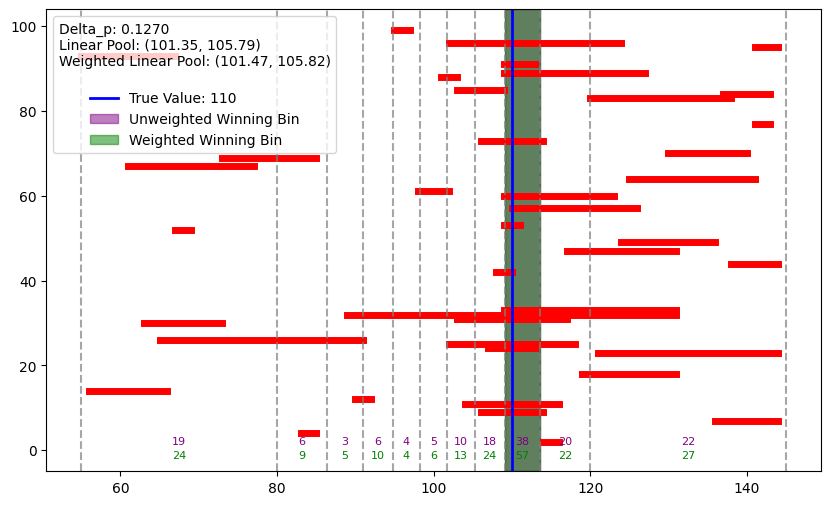


First two agent competencies: [0.25706404 0.35719254]
First two agent weights: [1.24130048 1.7150148 ]


In [ ]:
#Explanation of the parameters in paper notation:
#First, you can choose the number $n$ of agents for the simulation.
#Then you choose a target mean competency value for the agents, $\bar{p}^{\omega^*}, and how scattered the specific competency values should be around the mean by adjusting "COMPETENCY_STD".
#In this simulation, the competency values are restricted to values in the interval (0,1) to avoid divisions by 0.
#In a next step, "DISPERSION_STD" controls the imprecision of the agents' beliefs, i.e. the width of their belief interval.
#Then we set the number of bins $m$.
#Finally, we set information about the quantity, such as its range of values, its true value, and the mean of the distribution.


import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Parameters
NUM_AGENTS = 100
COMPETENCY_MEAN = 0.3  # Mean probability an agent holds the true value as belief
COMPETENCY_STD = 0.1   # Standard deviation for competency
COMPETENCY_MIN, COMPETENCY_MAX = 0.0001, 0.9999  # Bounds for competency
DISPERSION_STD = 7     # Standard deviation for belief dispersion
PERCENTILE_BINS = 11   # Number of bins

# Generate VALUE_RANGE and TRUE_VALUE
VALUE_RANGE = np.arange(55, 145)
TRUE_VALUE  = 110
#TRUE_VALUE = np.random.normal(loc=1207, scale=54.9)
#TRUE_VALUE = np.clip(round(TRUE_VALUE), 55, 146)

#Note that in order to adjust the standard deviation from the distribution, you need to adjust the value for "scale" in the following definition.

# Compute percentile bins ensuring equal probability per bin
percentile_values = stats.norm.ppf(np.linspace(0, 1, PERCENTILE_BINS + 1), loc=100, scale=15)
percentile_values[0], percentile_values[-1] = 55, 145  # Ensure boundaries match VALUE_RANGE

# Generate agent competencies
agent_competencies = np.clip(np.random.normal(loc=COMPETENCY_MEAN, scale=COMPETENCY_STD, size=NUM_AGENTS),
                             COMPETENCY_MIN, COMPETENCY_MAX)

# Compute agent weights using log-odds transformation
agent_weights = np.log(((PERCENTILE_BINS - 1) * agent_competencies) / (1 - agent_competencies))

# Generate value probabilities for individual values in VALUE_RANGE
value_probabilities = np.full(len(VALUE_RANGE), (1 - COMPETENCY_MEAN) / (len(VALUE_RANGE) - 1))
true_value_idx = np.where(VALUE_RANGE == TRUE_VALUE)[0][0]
value_probabilities[true_value_idx] = COMPETENCY_MEAN

# Generate agent beliefs with dispersion
agent_beliefs = []
for i in range(NUM_AGENTS):
    competency = agent_competencies[i]
    if np.random.rand() < competency:
        belief = TRUE_VALUE
    else:
        belief = np.random.choice(VALUE_RANGE[VALUE_RANGE != TRUE_VALUE])

    # Apply random dispersion using VALUE_RANGE boundaries for consistency
    dispersion_factor = max(0, int(np.random.normal(loc=0, scale=DISPERSION_STD)))
    belief_min = max(VALUE_RANGE[0], belief - dispersion_factor)
    belief_max = min(VALUE_RANGE[-1], belief + dispersion_factor)
    agent_beliefs.append((belief_min, belief_max))

# Count votes for each bin using unweighted and weighted aggregation
bin_votes = np.zeros(PERCENTILE_BINS)
weighted_bin_votes = np.zeros(PERCENTILE_BINS)
for i, (belief_min, belief_max) in enumerate(agent_beliefs):
    weight = agent_weights[i]
    for j in range(PERCENTILE_BINS):
        bin_start, bin_end = percentile_values[j], percentile_values[j + 1]
        if belief_max > bin_start and belief_min < bin_end:  # Check intersection
            bin_votes[j] += 1
            weighted_bin_votes[j] += weight



# Determine winning bins
winning_bin_index = np.argmax(bin_votes)
winning_bin = (percentile_values[winning_bin_index], percentile_values[winning_bin_index + 1])

weighted_winning_bin_index = np.argmax(weighted_bin_votes)
weighted_winning_bin = (percentile_values[weighted_winning_bin_index], percentile_values[weighted_winning_bin_index + 1])

# Compute Delta_p by aggregating probabilities for each bin
true_bin_index = None
for i in range(len(percentile_values) - 1):
    if percentile_values[i] <= TRUE_VALUE < percentile_values[i + 1]:
        true_bin_index = i
        break

bin_probabilities = np.zeros(len(percentile_values) - 1)
for j in range(len(percentile_values) - 1):
    bin_start, bin_end = percentile_values[j], percentile_values[j + 1]
    for k, value in enumerate(VALUE_RANGE):
        if bin_start <= value < bin_end:
            bin_probabilities[j] += value_probabilities[k]

sum_true_bin = bin_probabilities[true_bin_index]
max_other_bins = np.max([prob for j, prob in enumerate(bin_probabilities) if j != true_bin_index])
delta_p = sum_true_bin - max_other_bins
print(f"Delta_p: {delta_p}")

# Compute Linear Opinion Pool
#belief_mins = np.array([belief[0] for belief in agent_beliefs])
#belief_maxs = np.array([belief[1] for belief in agent_beliefs])
total_weight = np.sum(agent_weights)
#linear_pool_min = np.sum(belief_mins) / NUM_AGENTS
#linear_pool_max = np.sum(belief_maxs) / NUM_AGENTS
#linear_pool_interval = (linear_pool_min, linear_pool_max)

# Compute Linear Opinion Pool
belief_mins = np.array([belief[0] for belief in agent_beliefs])
belief_maxs = np.array([belief[1] for belief in agent_beliefs])

linear_pool_min = np.sum(belief_mins) / NUM_AGENTS
linear_pool_max = np.sum(belief_maxs) / NUM_AGENTS
linear_pool_interval = (linear_pool_min, linear_pool_max)

# Compute Weighted Linear Opinion Pool
weighted_linear_pool_min = np.sum(belief_mins * agent_weights) / total_weight
weighted_linear_pool_max = np.sum(belief_maxs * agent_weights) / total_weight
weighted_linear_pool_interval = (weighted_linear_pool_min, weighted_linear_pool_max)

# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))
for i, (belief_min, belief_max) in enumerate(agent_beliefs):
    ax.plot([belief_min, belief_max], [i, i], 'r-', linewidth=5)  # Plot each agent's belief interval

# Add vertical lines for bins
for boundary in percentile_values:
    ax.axvline(boundary, color='gray', linestyle='--', alpha=0.7)

# Highlight the true value
ax.axvline(TRUE_VALUE, color='blue', linestyle='-', linewidth=2, label=f'True Value: {TRUE_VALUE}')

# Color the winning bins for unweighted and weighted voting
ax.axvspan(percentile_values[winning_bin_index], percentile_values[winning_bin_index + 1],
           color='purple', alpha=0.5, label='Unweighted Winning Bin')
ax.axvspan(percentile_values[weighted_winning_bin_index], percentile_values[weighted_winning_bin_index + 1],
           color='green', alpha=0.5, label='Weighted Winning Bin')

# Add text to show the number of votes in each bin (unweighted at the top, weighted at the bottom)
for j in range(PERCENTILE_BINS):
    ax.text((percentile_values[j] + percentile_values[j + 1]) / 2, 1.05, str(int(bin_votes[j])),
            ha='center', va='bottom', fontsize=8, color='purple')
    ax.text((percentile_values[j] + percentile_values[j + 1]) / 2, -0.05, str(int(weighted_bin_votes[j])),
            ha='center', va='top', fontsize=8, color='green')

#ax.set_xlabel("Quantity")
#ax.set_ylabel("Agents")
#ax.set_title("Agent Belief Intervals")

ax.legend(
    title=(
        f'Delta_p: {delta_p:.4f}\n'
        f'Linear Pool: ({linear_pool_min:.2f}, {linear_pool_max:.2f})\n'
        f'Weighted Linear Pool: ({weighted_linear_pool_min:.2f}, {weighted_linear_pool_max:.2f})\n'
    ),
    loc='upper left'  # Forces the legend to always be in the top-left corner
)

plt.savefig('high_quality_plot.png', dpi=300)
plt.show()


# Print results
#print(f"\nTrue IQ Value: {TRUE_VALUE}")
#print(f"Winning Bin (Unweighted): {winning_bin}")
#print(f"Winning Bin (Weighted): {weighted_winning_bin}")
#print(f"Bin Votes (Unweighted): {bin_votes}")
#print(f"Bin Votes (Weighted): {weighted_bin_votes}")
#print(f"percentile_values: {percentile_values}")

# Print competencies and weights for the first two agents
print("\nFirst two agent competencies:", agent_competencies[:2])
print("First two agent weights:", agent_weights[:2])


Unweighted Aggregation - Exponential Distribution - No Correlation

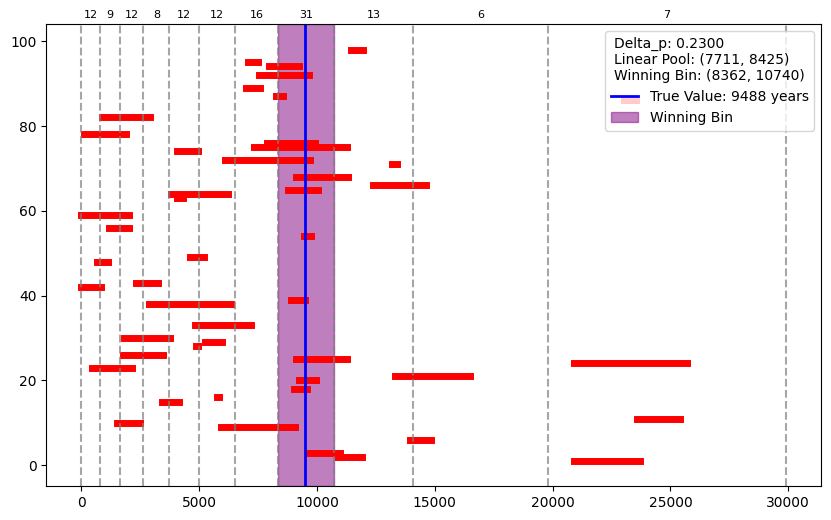


True Decay Time: 9488 years
Winning Bin: (8362, 10740)
Bin Votes: [12.  9. 12.  8. 12. 12. 16. 31. 13.  6.  7.]
Percentile Values: [    0   788  1659  2632  3736  5010  6517  8362 10740 14091 19821 29900]


In [ ]:
#Explanation of the parameters in paper notation:
#First, you can choose the number $n$ of agents for the simulation.
#Then you choose a target mean competency value for the agents, $\bar{p}^{\omega^*}, and how scattered the specific competency values should be around the mean by adjusting "COMPETENCY_STD".
#In this simulation, the competency values are restricted to values in the interval (0,1) to avoid divisions by 0.
#In a next step, "DISPERSION_STD" controls the imprecision of the agents' beliefs, i.e. the width of their belief interval.
#Then we set the number of bins $m$.
#Finally, we set information about the quantity, such as its range of values, its true value, and the mean of the distribution.


import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
from typing import List, Tuple

# Parameters
NUM_AGENTS = 100
COMPETENCY_MEAN = 0.3
COMPETENCY_STD = 0.2
COMPETENCY_MIN, COMPETENCY_MAX = 0.0001, 0.9999
DISPERSION_STD = 1000  # Larger dispersion due to decay scale
PERCENTILE_BINS = 11  # Number of bins
MEAN_DECAY_TIME = 8266  # Mean decay time for Carbon-14
VALUE_RANGE = np.arange(0, 30000, 100)  # Simulated time values in years
TRUE_VALUE = np.random.exponential(scale=MEAN_DECAY_TIME)  # True decay time

def generate_exponential_bins(mean_decay: float, bins: int) -> np.ndarray:
    """Generates bin boundaries ensuring equal probability mass for an exponential distribution."""
    percentiles = np.linspace(0, 1, bins + 1)
    bin_edges = stats.expon.ppf(percentiles, scale=mean_decay)
    bin_edges[-1] = VALUE_RANGE[-1]  # Ensure last bin captures all remaining values
    return np.round(bin_edges).astype(int)

def find_true_bin(true_value: int, bins: np.ndarray) -> int:
    """Find the bin containing the true value."""
    return np.searchsorted(bins, true_value, side='right') - 1

def generate_agent_competencies(num_agents: int, mean: float, std: float, min_val: float, max_val: float) -> np.ndarray:
    """Generate agent competencies with clipping."""
    return np.clip(np.random.normal(loc=mean, scale=std, size=num_agents), min_val, max_val)

def compute_agent_weights(competencies: np.ndarray, percentile_bins: int) -> np.ndarray:
    """Compute agent weights using log-odds transformation."""
    return np.log(((percentile_bins - 1) * competencies) / (1 - competencies))

def generate_agent_beliefs(value_range: np.ndarray, value_probabilities: np.ndarray, num_agents: int, dispersion_std: int) -> List[Tuple[int, int]]:
    """Generate agent beliefs with dispersion."""
    beliefs = []
    for _ in range(num_agents):
        belief = np.random.choice(value_range, p=value_probabilities / np.sum(value_probabilities))
        dispersion_factor = max(0, int(np.random.normal(loc=0, scale=dispersion_std)))
        belief_min = max(value_range[0], belief - dispersion_factor)
        belief_max = min(value_range[-1], belief + dispersion_factor)
        beliefs.append((belief_min, belief_max))
    return beliefs

def count_bin_votes(agent_beliefs: List[Tuple[int, int]], bins: np.ndarray) -> np.ndarray:
    """Count votes for each bin."""
    bin_votes = np.zeros(len(bins) - 1)
    for belief_min, belief_max in agent_beliefs:
        for j in range(len(bins) - 1):
            bin_start, bin_end = bins[j], bins[j + 1]
            if belief_max > bin_start and belief_min < bin_end:
                bin_votes[j] += 1
    return bin_votes

# Generate bins
percentile_values = generate_exponential_bins(MEAN_DECAY_TIME, PERCENTILE_BINS)

# Find the bin containing the true value
true_bin_index = find_true_bin(TRUE_VALUE, percentile_values)

# Generate agent competencies and weights
#agent_competencies = generate_agent_competencies(NUM_AGENTS, COMPETENCY_MEAN, COMPETENCY_STD, COMPETENCY_MIN, COMPETENCY_MAX)
#agent_weights = compute_agent_weights(agent_competencies, PERCENTILE_BINS)

# Normalize weights
#normalized_weights = agent_weights / np.sum(agent_weights)

# Initialize bin probabilities
bin_probabilities = np.full(PERCENTILE_BINS, (1 - COMPETENCY_MEAN) / (PERCENTILE_BINS - 1))
bin_probabilities[true_bin_index] = COMPETENCY_MEAN

# Generate probabilities for individual values in each bin
value_probabilities = np.zeros(len(VALUE_RANGE))
for j in range(PERCENTILE_BINS):
    bin_start, bin_end = percentile_values[j], percentile_values[j + 1]
    bin_values = VALUE_RANGE[(VALUE_RANGE >= bin_start) & (VALUE_RANGE < bin_end)]
    if len(bin_values) > 0:
        value_probabilities[(VALUE_RANGE >= bin_start) & (VALUE_RANGE < bin_end)] = bin_probabilities[j] / len(bin_values)

# Generate agent beliefs
agent_beliefs = generate_agent_beliefs(VALUE_RANGE, value_probabilities, NUM_AGENTS, DISPERSION_STD)

# Count votes for each bin
bin_votes = count_bin_votes(agent_beliefs, percentile_values)

# Determine winning bin
winning_bin_index = np.argmax(bin_votes)
winning_bin = (percentile_values[winning_bin_index], percentile_values[winning_bin_index + 1])

# Compute delta_p
sum_true_bin = bin_probabilities[true_bin_index]
max_other_bins = np.max([prob for j, prob in enumerate(bin_probabilities) if j != true_bin_index])
delta_p = sum_true_bin - max_other_bins

# Compute Linear Opinion Pool
belief_mins = np.array([belief[0] for belief in agent_beliefs])
belief_maxs = np.array([belief[1] for belief in agent_beliefs])

linear_pool_min = np.sum(belief_mins) / NUM_AGENTS
linear_pool_max = np.sum(belief_maxs) / NUM_AGENTS
linear_pool_interval = (linear_pool_min, linear_pool_max)

# Compute Weighted Linear Opinion Pool
#weighted_linear_pool_min = np.sum(belief_mins * normalized_weights)
#weighted_linear_pool_max = np.sum(belief_maxs * normalized_weights)
#weighted_linear_pool_interval = (weighted_linear_pool_min, weighted_linear_pool_max)

# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))
for i, (belief_min, belief_max) in enumerate(agent_beliefs):
    ax.plot([belief_min, belief_max], [i, i], 'r-', linewidth=5)

# Add bin boundaries
for boundary in percentile_values:
    ax.axvline(boundary, color='gray', linestyle='--', alpha=0.7)

# Highlight the true value
ax.axvline(TRUE_VALUE, color='blue', linestyle='-', linewidth=2, label=f'True Value: {TRUE_VALUE:.0f} years')

# Highlight the winning bin
ax.axvspan(percentile_values[winning_bin_index], percentile_values[winning_bin_index + 1], color='purple', alpha=0.5, label='Winning Bin')

# Add text showing the number of votes per bin
for j in range(PERCENTILE_BINS):
    ax.text((percentile_values[j] + percentile_values[j + 1]) / 2, NUM_AGENTS + 5, str(int(bin_votes[j])),
            ha='center', va='bottom', fontsize=8, color='black')

ax.legend(
    title=(
        f'Delta_p: {delta_p:.4f}\n'
        f'Linear Pool: ({linear_pool_min:.0f}, {linear_pool_max:.0f})\n'
        #f'Weighted Pool: ({weighted_linear_pool_min:.0f}, {weighted_linear_pool_max:.0f})\n'
        f'Winning Bin: ({winning_bin[0]:.0f}, {winning_bin[1]:.0f})'
    ),
    loc='upper right'
)

plt.savefig('radioactive_decay_simulation.png', dpi=300)
plt.show()

# Print results
print(f"\nTrue Decay Time: {TRUE_VALUE:.0f} years")
print(f"Winning Bin: {winning_bin}")
print(f"Bin Votes: {bin_votes}")
print(f"Percentile Values: {percentile_values}")

Unweighted Aggregation - Normal Distribution - Correlation through Opinion Leader

<ipython-input-4-602226159838>:147: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  ax.plot([opinion_leader_min, opinion_leader_max], [NUM_AGENTS, NUM_AGENTS], 'b-', linewidth=5, color='green', label='Opinion Leader')


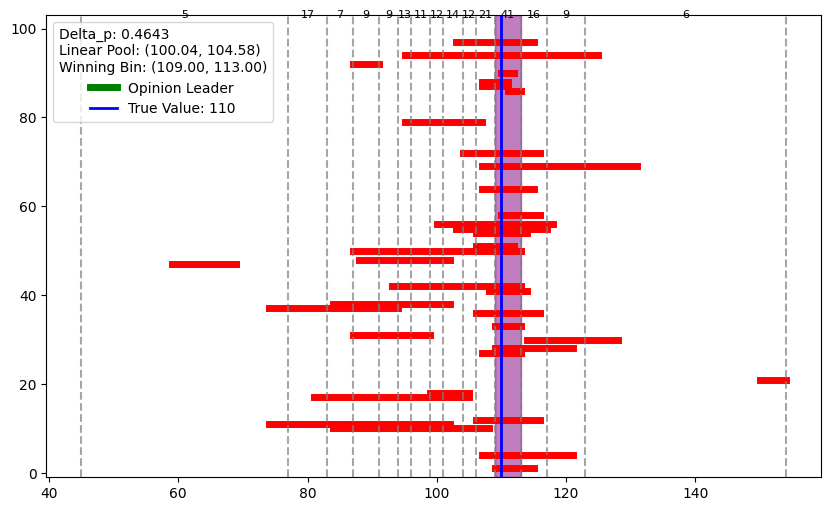

In [ ]:
#Explanation of the parameters in paper notation:
#First, you can choose the number $n$ of agents for the simulation.
#Then you choose a target mean competency value for the agents, $\bar{p}^{\omega^*}, and how scattered the specific competency values should be around the mean by adjusting "COMPETENCY_STD".
#In this simulation, the competency values are restricted to values in the interval (0,1) to avoid divisions by 0.
#In a next step, "DISPERSION_STD" controls the imprecision of the agents' beliefs, i.e. the width of their belief interval.
#Then we set the number of bins $m$.
#We set information about the quantity, such as its range of values, its true value, and the mean of the distribution.
#Additionally, we choose the OL's competency value $\hat{p}$ as well as her influence factor $\pi$.



import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
from typing import List, Tuple

# Parameters
NUM_AGENTS = 100
COMPETENCY_MEAN = 0.5  # Mean probability an agent holds the true value as belief
COMPETENCY_STD = 0.2  # Standard deviation for competency
COMPETENCY_MIN, COMPETENCY_MAX = 0.0001, 0.9999  # Bounds for competency
DISPERSION_STD = 8  # Standard deviation for belief dispersion
PERCENTILE_BINS = 15  # Number of bins
VALUE_RANGE = np.arange(45, 155)
TRUE_VALUE = 110  # Fixed true value
DISTRIBUTION_MEAN = 100  # Can now be different from TRUE_VALUE
OPINION_LEADER_COMPETENCE = 0.5  # Competence value for the opinion leader
INFLUENCE_FACTOR = 0.1  # Probability of an agent copying the opinion leader's belief

#Note that in order to adjust the standard deviation from the distribution, you need to adjust the value for "scale" in the following definition.


def generate_bins(distribution_mean: int, value_range: np.ndarray, percentile_bins: int) -> np.ndarray:
    """Generate symmetric bins around the mean, with larger bins at the outskirts."""
    percentiles = np.linspace(0, 1, percentile_bins + 1)
    percentile_values = stats.norm.ppf(percentiles, loc=distribution_mean, scale=15)
    percentile_values[0] = value_range[0]
    percentile_values[-1] = value_range[-1]
    percentile_values = np.array([math.floor(percentile_values[0])] +
                                 [round(val) for val in percentile_values[1:-1]] +
                                 [math.ceil(percentile_values[-1])])
    return percentile_values

def find_true_bin(true_value: int, bins: np.ndarray) -> int:
    """Find the bin containing the true value."""
    return np.searchsorted(bins, true_value, side='right') - 1

def generate_agent_competencies(num_agents: int, mean: float, std: float, min_val: float, max_val: float) -> np.ndarray:
    """Generate agent competencies with clipping."""
    return np.clip(np.random.normal(loc=mean, scale=std, size=num_agents), min_val, max_val)

def compute_agent_weights(competencies: np.ndarray, percentile_bins: int) -> np.ndarray:
    """Compute agent weights using log-odds transformation."""
    return np.log(((percentile_bins - 1) * competencies) / (1 - competencies))

def generate_agent_beliefs(value_range: np.ndarray, value_probabilities: np.ndarray, num_agents: int, dispersion_std: int) -> List[Tuple[int, int]]:
    """Generate agent beliefs with dispersion."""
    beliefs = []
    for _ in range(num_agents):
        belief = np.random.choice(value_range, p=value_probabilities / np.sum(value_probabilities))
        dispersion_factor = max(0, int(np.random.normal(loc=0, scale=dispersion_std)))
        belief_min = max(value_range[0], belief - dispersion_factor)
        belief_max = min(value_range[-1], belief + dispersion_factor)
        beliefs.append((belief_min, belief_max))
    return beliefs

def generate_opinion_leader_belief(value_range: np.ndarray, value_probabilities: np.ndarray, dispersion_std: int) -> Tuple[int, int]:
    """Generate the opinion leader's belief with dispersion."""
    belief = np.random.choice(value_range, p=value_probabilities / np.sum(value_probabilities))
    dispersion_factor = max(0, int(np.random.normal(loc=0, scale=dispersion_std)))
    belief_min = max(value_range[0], belief - dispersion_factor)
    belief_max = min(value_range[-1], belief + dispersion_factor)
    return (belief_min, belief_max)

def count_bin_votes(agent_beliefs: List[Tuple[int, int]], bins: np.ndarray) -> np.ndarray:
    """Count votes for each bin."""
    bin_votes = np.zeros(len(bins) - 1)
    for belief_min, belief_max in agent_beliefs:
        for j in range(len(bins) - 1):
            bin_start, bin_end = bins[j], bins[j + 1]
            if belief_max > bin_start and belief_min < bin_end:  # Check intersection
                bin_votes[j] += 1
    return bin_votes

# Generate bins
percentile_values = generate_bins(DISTRIBUTION_MEAN, VALUE_RANGE, PERCENTILE_BINS)

# Find the bin containing the true value
true_bin_index = find_true_bin(TRUE_VALUE, percentile_values)

# Generate agent competencies and weights
agent_competencies = generate_agent_competencies(NUM_AGENTS, COMPETENCY_MEAN, COMPETENCY_STD, COMPETENCY_MIN, COMPETENCY_MAX)
agent_weights = compute_agent_weights(agent_competencies, PERCENTILE_BINS)

# Initialize bin probabilities
bin_probabilities = np.full(PERCENTILE_BINS, (1 - COMPETENCY_MEAN) / (PERCENTILE_BINS - 1))
bin_probabilities[true_bin_index] = COMPETENCY_MEAN

# Generate probabilities for individual values in each bin
value_probabilities = np.zeros(len(VALUE_RANGE))
for j in range(PERCENTILE_BINS):
    bin_start, bin_end = percentile_values[j], percentile_values[j + 1]
    bin_values = VALUE_RANGE[(VALUE_RANGE >= bin_start) & (VALUE_RANGE < bin_end)]
    if len(bin_values) > 0:
        value_probabilities[(VALUE_RANGE >= bin_start) & (VALUE_RANGE < bin_end)] = bin_probabilities[j] / len(bin_values)

# Generate opinion leader's belief
opinion_leader_belief = generate_opinion_leader_belief(VALUE_RANGE, value_probabilities, DISPERSION_STD)

# Generate agent beliefs
agent_beliefs = generate_agent_beliefs(VALUE_RANGE, value_probabilities, NUM_AGENTS, DISPERSION_STD)

# Apply influence factor
for i in range(NUM_AGENTS):
    if np.random.rand() < INFLUENCE_FACTOR:
        agent_beliefs[i] = opinion_leader_belief

# Count votes for each bin
bin_votes = count_bin_votes(agent_beliefs, percentile_values)

# Determine winning bin
winning_bin_index = np.argmax(bin_votes)
winning_bin = (percentile_values[winning_bin_index], percentile_values[winning_bin_index + 1])

# Compute delta_p
sum_true_bin = bin_probabilities[true_bin_index]
max_other_bins = np.max([prob for j, prob in enumerate(bin_probabilities) if j != true_bin_index])
delta_p = sum_true_bin - max_other_bins

# Compute Linear Opinion Pool
belief_mins = np.array([belief[0] for belief in agent_beliefs])
belief_maxs = np.array([belief[1] for belief in agent_beliefs])
linear_pool_min = np.sum(belief_mins) / NUM_AGENTS
linear_pool_max = np.sum(belief_maxs) / NUM_AGENTS
linear_pool_interval = (linear_pool_min, linear_pool_max)

# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))

# Plot regular agents
for i, (belief_min, belief_max) in enumerate(agent_beliefs):  # Plot all agents (excludes opinion leader)
    ax.plot([belief_min, belief_max], [i, i], 'r-', linewidth=5)

# Plot opinion leader's belief as a vertical bar (for visualization only)
opinion_leader_min, opinion_leader_max = opinion_leader_belief  # Get opinion leader's belief
ax.plot([opinion_leader_min, opinion_leader_max], [NUM_AGENTS, NUM_AGENTS], 'b-', linewidth=5, color='green', label='Opinion Leader')

# Add bin boundaries
for boundary in percentile_values:
    ax.axvline(boundary, color='gray', linestyle='--', alpha=0.7)

# Add true value line
ax.axvline(TRUE_VALUE, color='blue', linestyle='-', linewidth=2, label=f'True Value: {TRUE_VALUE}')

# Highlight winning bin
ax.axvspan(percentile_values[winning_bin_index], percentile_values[winning_bin_index + 1], color='purple', alpha=0.5)

# Add bin vote counts
for j in range(PERCENTILE_BINS):
    ax.text((percentile_values[j] + percentile_values[j + 1]) / 2, NUM_AGENTS + 2, str(int(bin_votes[j])),
            ha='center', va='bottom', fontsize=8, color='black')

# Add legend
ax.legend(
    title=f'Delta_p: {delta_p:.4f}\nLinear Pool: ({linear_pool_min:.2f}, {linear_pool_max:.2f})\nWinning Bin: ({winning_bin[0]:.2f}, {winning_bin[1]:.2f})',
    loc='upper left'
)

# Adjust y-axis limits to make room for the opinion leader
ax.set_ylim(-1, NUM_AGENTS + 3)  # Add extra space at the bottom

# Save and show the plot
plt.savefig('high_quality_plot.png', dpi=300)
plt.show()

